In [1]:
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import statistics
import numpy as np
from numpy import genfromtxt
from sklearn.model_selection import cross_val_predict
from sklearn import datasets, linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import statistics

from scipy import stats


### Generate The differnt downsample and data splits

#### Downsampling

In [2]:
# invalid bad practice dont use...
def downsampling_pre_split(feature_data, random_state):
    dataset_majority = feature_data[feature_data["PHQ8_Binary"]==0]
    dataset_minority = feature_data[feature_data["PHQ8_Binary"]==1]
    
    dataset_majority_downsampled = resample(dataset_majority, 
                                 replace=False,    
                                 n_samples=len(dataset_minority), random_state = random_state)
    
    dataset_downsampled = pd.concat([dataset_majority_downsampled, dataset_minority])
    return dataset_downsampled
    

In [3]:
def downsampling_post_split(X_train, Y_train, random_state):
    tempfeatures = X_train.copy()
    tempfeatures.insert(loc=1, column = 'PHQ8_binary', value=Y_train)
    
    dataset_majority = tempfeatures[tempfeatures["PHQ8_binary"]==0]
    dataset_minority = tempfeatures[tempfeatures["PHQ8_binary"]==1]
    
    dataset_majority_downsampled = resample(dataset_majority, 
                                 replace=False,    
                                 n_samples=len(dataset_minority), random_state = random_state)
    
    dataset_downsampled = pd.concat([dataset_majority_downsampled, dataset_minority])    
    Y_train_down = dataset_downsampled['PHQ8_binary']
    X_train_down = dataset_downsampled.drop(['PHQ8_binary'], axis=1).copy()    
  
    return X_train_down, Y_train_down

In [4]:
def downsampling_gender(X_train, Y_train, random_state):
    tempfeatures = X_train.copy()
    tempfeatures.insert(loc=1, column = 'PHQ8_binary', value=Y_train)
    
    dataset_majority_male = tempfeatures[(tempfeatures["PHQ8_binary"]==0) & (tempfeatures["Gender"]==1) ]
    dataset_minority_male = tempfeatures[(tempfeatures["PHQ8_binary"]==1) & (tempfeatures["Gender"]==1) ]
    dataset_majority_female = tempfeatures[(tempfeatures["PHQ8_binary"]==0) & (tempfeatures["Gender"]==0) ]
    dataset_minority_female = tempfeatures[(tempfeatures["PHQ8_binary"]==1) & (tempfeatures["Gender"]==0) ]

    smallest_count = (min(len(dataset_majority_male), len(dataset_minority_male), len(dataset_majority_female), len(dataset_minority_female)))

    dataset_majority_male_downsampled = resample(dataset_majority_male, 
                                     replace=False,    
                                     n_samples=smallest_count, random_state = random_state)
    dataset_minority_male_downsampled = resample(dataset_minority_male, 
                                     replace=False,    
                                     n_samples=smallest_count, random_state = random_state)
    dataset_majority_female_downsampled = resample(dataset_majority_female, 
                                     replace=False,    
                                     n_samples=smallest_count, random_state = random_state)
    dataset_minority_female_downsampled = resample(dataset_minority_female, 
                                     replace=False,    
                                     n_samples=smallest_count, random_state = random_state)

    dataset_downsampled = pd.concat([dataset_majority_male_downsampled, dataset_minority_male_downsampled ,dataset_majority_female_downsampled , dataset_minority_female_downsampled])
    Y_train_down = dataset_downsampled['PHQ8_binary']
    X_train_down = dataset_downsampled.drop(['PHQ8_binary'], axis=1).copy()  
    
    return X_train_down, Y_train_down
    

#### Data Splits

##### Benchmark Offical Split of the Dataset

In [5]:
def benchmark_split (feature_data):
    X_train_Bench = feature_data.loc[feature_data['data_set'] == 0]
    Y_train_Bench = feature_data['PHQ8_Binary'].loc[feature_data['data_set'] == 0]
    #print(Y_train_Bench)
    X_train_Bench.drop("PHQ8_Binary", axis=1, inplace=True)
    X_train_Bench.drop(["PHQ8_Score",  "data_set", "patient_id"], axis=1, inplace=True)

    X_test_Bench = feature_data.loc[feature_data['data_set'] == 2]
    Y_test_Bench = feature_data['PHQ8_Binary'].loc[feature_data['data_set'] == 2]
    X_test_Bench.drop("PHQ8_Binary", axis=1, inplace=True)
    X_test_Bench.drop(["PHQ8_Score", "Gender", "data_set", "patient_id"], axis=1, inplace=True)
    
    return X_train_Bench,X_test_Bench, Y_train_Bench, Y_test_Bench


##### Extreme PHQ8 Scores only, Downsampled to MDD class

In [6]:
def extreme_mdd_marks7030(feature_data, random_state):
    high_scores = feature_data.loc[feature_data['PHQ8_Score'] <= 17]
    low_scores = high_scores.loc[feature_data['PHQ8_Score'] >= 5]
    #low_scores_downsampled = resample(low_scores, 
    #                             replace=False,    
    #                             n_samples=len(high_scores), random_state = random_state)
    
    dataset_extremes = pd.concat([low_scores, high_scores])
    
    X_features = dataset_extremes.drop(["PHQ8_Binary","PHQ8_Score",  "data_set", "patient_id"], axis=1)
    Y_MDD_binary = dataset_extremes['PHQ8_Binary']
    X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_MDD_binary, test_size = 0.30,  random_state = random_state, stratify = Y_MDD_binary)  
    X_test = X_test.drop(["Gender"], axis=1)
    return X_train, X_test, Y_train, Y_test
        

In [7]:
def Oextreme_mdd_marks7030(feature_data, random_state):
    high_scores = feature_data.loc[feature_data['PHQ8_Score'] >= 19]
    low_scores = feature_data.loc[feature_data['PHQ8_Score'] <= 5]
    low_scores = low_scores.loc[low_scores['PHQ8_Score'] >= 1 ]
    low_scores_downsampled = resample(low_scores, 
                                 replace=False,    
                                 n_samples=len(high_scores), random_state = random_state)
    
    dataset_extremes = pd.concat([low_scores_downsampled, high_scores])
    
    X_features = dataset_extremes.drop(["PHQ8_Binary","PHQ8_Score", "data_set", "patient_id"], axis=1)
    Y_MDD_binary = dataset_extremes['PHQ8_Binary']
    X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_MDD_binary, test_size = 0.30,  random_state = random_state, stratify = Y_MDD_binary)  
    X_test = X_test.drop(["Gender"], axis=1)
    return X_train, X_test, Y_train, Y_test
        

##### Random Data Split 80/20

In [8]:
def random_data_nd_8020(feature_data, random_state):
    X_features = feature_data.drop(["PHQ8_Binary","PHQ8_Score",  "data_set", "patient_id"], axis=1)
    Y_MDD_binary = feature_data['PHQ8_Binary']
    ##### Random Data Split 70/30
    X_train_80, X_test_20, Y_train_80, Y_test_20 = train_test_split(X_features, Y_MDD_binary, test_size = 0.20,  random_state = random_state, stratify = Y_MDD_binary)
    X_test_20 = X_test_20.drop(["Gender"], axis=1)
    return X_train_80, X_test_20, Y_train_80, Y_test_20

##### Random Data Split 70/30

In [9]:
def random_data_nd_7030(feature_data, random_state):
    X_features = feature_data.drop(["PHQ8_Binary","PHQ8_Score",  "data_set", "patient_id"], axis=1)
    Y_MDD_binary = feature_data['PHQ8_Binary']
    X_test = X_test.drop(["Gender"], axis=1)
    X_train_70, X_test_30, Y_train_70, Y_test_30 = train_test_split(X_features, Y_MDD_binary, test_size = 0.30, random_state = random_state, stratify = Y_MDD_binary)
    X_test_30 = X_test_30.drop(["Gender"], axis=1)
    return X_train_70, X_test_30, Y_train_70, Y_test_30

#### Split 90/10

In [10]:
def random_data_nd_9010(feature_data, random_state):
    X_features = feature_data.drop(["PHQ8_Binary","PHQ8_Score",  "data_set", "patient_id"], axis=1)
    Y_MDD_binary = feature_data['PHQ8_Binary']
    
    X_train_90, X_test_10, Y_train_90, Y_test_10 = train_test_split(X_features, Y_MDD_binary, test_size = 0.10,  random_state = random_state, stratify = Y_MDD_binary)
    X_test_90 = X_test_90.drop(["Gender"], axis=1)
    return X_train_90, X_test_10, Y_train_90, Y_test_10

##### Feature Groups, Feature selection

In [11]:
def feature_basic_set(data_table):
    basic_feature = data_table[["patient_id", "PHQ8_Binary","PHQ8_Score", "Gender", "data_set", "duration", "meanF0Hz", "stdevF0Hz", "F0_min", "F0_max", "localJitter" , "localShimmer"]]   
    return basic_feature

In [160]:
def basic_set_plus(data_table):
    basic_feature = data_table[["patient_id", "PHQ8_Binary","PHQ8_Score", "Gender", "data_set", 
                                "duration", "meanF0Hz", "stdevF0Hz", "F0_min", "F0_max", "localJitter" ,
                                "localShimmer", "max_F0_range_m_mean_o_sd", "max_F0_Range_rel_mean", "max_rel_F0grad_o_mean",
                               "sd_F0_range_m_mean_o_sd", "sd_rel_F0grad_m_mean_o_sd"]]   
    return basic_feature

In [161]:

def basic_set_viatal(data_table):
    basic_feature = data_table[["patient_id", "PHQ8_Binary","PHQ8_Score", "Gender", "data_set", "duration", "meanF0Hz", "stdevF0Hz", "F0_min", "F0_max", "localJitter" ,
                                "localShimmer", "vitality_comp"]]   
    return basic_feature

In [12]:
def emotion_features(X_train, X_test):

        scaler = MinMaxScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        
        pca = PCA(n_components= 1)
        X_train_feature = pca.fit_transform(X_train_s)
        X_test_feature = pca.transform(X_test_s)
    
        
        
        
        return X_train_feature, X_test_feature

        


##### Features from COVERAP Only

In [13]:
def Co_feature_group(data_table):
    co_feature = data_table[["patient_id", "PHQ8_Binary","PHQ8_Score", "Gender", "data_set", 
                             "F0_C_mean" ,"NAQ_mean", "QoQ_mean", "H1H2_mean", "PSP_mean", 'MDQ_mean', "peakSlope_mean", "RdShape_mean", 
                             "Rd_Conf_mean", "Creak_mean", "MCEP_0_mean", "MCEP_1_mean", "MCEP_2_mean", "MCEP_3_mean", "MCEP_4_mean", 
                             "MCEP_5_mean", "MCEP_6_mean", "MCEP_7_mean", "MCEP_8_mean", "MCEP_9_mean", "MCEP_10_mean", "MCEP_11_mean", 
                             "MCEP_12_mean", "MCEP_13_mean", "MCEP_14_mean", "MCEP_15_mean", "MCEP_16_mean", "MCEP_17_mean", 
                             "MCEP_18_mean", "MCEP_19_mean", "MCEP_20_mean", "MCEP_21_mean", "MCEP_22_mean", "MCEP_23_mean", 
                             "MCEP_24_mean", "HMPDM_0_mean", "HMPDM_1_mean", "HMPDM_2_mean", "HMPDM_3_mean", "HMPDM_4_mean", 
                             "HMPDM_5_mean", "HMPDM_6_mean", "HMPDM_7_mean", "HMPDM_8_mean", "HMPDM_9_mean", "HMPDM_10_mean", 
                             "HMPDM_11_mean", "HMPDM_12_mean", "HMPDM_13_mean", "HMPDM_14_mean", "HMPDM_15_mean", "HMPDM_16_mean", 
                             "HMPDM_17_mean", "HMPDM_18_mean", "HMPDM_19_mean", "HMPDM_20_mean", "HMPDM_21_mean", "HMPDM_22_mean", 
                             "HMPDM_23_mean", "HMPDM_24_mean", "HMPDD_0_mean", "HMPDD_1_mean", "HMPDD_2_mean", "HMPDD_3_mean", 
                             "HMPDD_4_mean", "HMPDD_5_mean", "HMPDD_6_mean", "HMPDD_7_mean", "HMPDD_8_mean", "HMPDD_9_mean", 
                             "HMPDD_10_mean", "HMPDD_11_mean", "HMPDD_12_mean", "F0_C_median", "NAQ_median", "QoQ_median", "H1H2_median", 
                             "PSP_median", "MDQ_median", "peakSlope_median", "RdShape_median", "Rd_Conf_median", "Creak_median", 
                             "MCEP_0_median", "MCEP_1_median", "MCEP_2_median", "MCEP_3_median", "MCEP_4_median", "MCEP_5_median", 
                             "MCEP_6_median", "MCEP_7_median", "MCEP_8_median", "MCEP_9_median", "MCEP_10_median", "MCEP_11_median", 
                             "MCEP_12_median", "MCEP_13_median", "MCEP_14_median", "MCEP_15_median", "MCEP_16_median", "MCEP_17_median", 
                             "MCEP_18_median", "MCEP_19_median", "MCEP_20_median", "MCEP_21_median", "MCEP_22_median", "MCEP_23_median", 
                             "MCEP_24_median", "HMPDM_0_median", "HMPDM_1_median", "HMPDM_2_median", "HMPDM_3_median", "HMPDM_4_median", 
                             "HMPDM_5_median", "HMPDM_6_median", "HMPDM_7_median", "HMPDM_8_median", "HMPDM_9_median", 'HMPDM_10_median', 
                             "HMPDM_11_median", "HMPDM_12_median", "HMPDM_13_median", "HMPDM_14_median", "HMPDM_15_median", 
                             "HMPDM_16_median", "HMPDM_17_median", "HMPDM_18_median", "HMPDM_19_median", "HMPDM_20_median", 
                             "HMPDM_21_median", "HMPDM_22_median", "HMPDM_23_median", "HMPDM_24_median", "HMPDD_0_median", "HMPDD_1_median", 
                             "HMPDD_2_median", "HMPDD_3_median", "HMPDD_4_median", "HMPDD_5_median", "HMPDD_6_median", "HMPDD_7_median", 
                             "HMPDD_8_median", "HMPDD_9_median", "HMPDD_10_median", "HMPDD_11_median", "HMPDD_12_median", "F0_C_sd", "NAQ_sd", 
                             "QoQ_sd", "H1H2_sd", "PSP_sd", "MDQ_sd", "peakSlope_sd", "RdShape_sd", "Rd_Conf_sd", "Creak_sd", "MCEP_0_sd", 
                             "MCEP_1_sd", "MCEP_2_sd", "MCEP_3_sd", "MCEP_4_sd", "MCEP_5_sd", "MCEP_6_sd", "MCEP_7_sd", "MCEP_8_sd", 
                             "MCEP_9_sd", "MCEP_10_sd", "MCEP_11_sd", "MCEP_12_sd", "MCEP_13_sd", "MCEP_14_sd", "MCEP_15_sd", "MCEP_16_sd", 
                             "MCEP_17_sd", "MCEP_18_sd", "MCEP_19_sd", "MCEP_20_sd", "MCEP_21_sd", "MCEP_22_sd", "MCEP_23_sd", "MCEP_24_sd", 
                             "HMPDM_0_sd", "HMPDM_1_sd", "HMPDM_2_sd", "HMPDM_3_sd", "HMPDM_4_sd", "HMPDM_5_sd", "HMPDM_6_sd", "HMPDM_7_sd", 
                             "HMPDM_8_sd", "HMPDM_9_sd", "HMPDM_10_sd", "HMPDM_11_sd", "HMPDM_12_sd", "HMPDM_13_sd", "HMPDM_14_sd", 
                             "HMPDM_15_sd", "HMPDM_16_sd", "HMPDM_17_sd", "HMPDM_18_sd", "HMPDM_19_sd", "HMPDM_20_sd", "HMPDM_21_sd",
                             "HMPDM_22_sd", "HMPDM_23_sd", "HMPDM_24_sd", "HMPDD_0_sd", "HMPDD_1_sd", "HMPDD_2_sd", "HMPDD_3_sd", "HMPDD_4_sd", 
                             "HMPDD_5_sd", "HMPDD_6_sd", "HMPDD_7_sd", "HMPDD_8_sd", "HMPDD_9_sd", "HMPDD_10_sd", "HMPDD_11_sd", "HMPDD_12_sd"]]
    
    return co_feature


### Feleature Selection of Extraction Methods

In [14]:
def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
   
    X_train_s = scaler.fit_transform(X_train)
    
    if X_test.empty:
        return X_train_s
    X_test_s = scaler.transform(X_test)

    return X_train_s, X_test_s

In [15]:
def pca_training(X_train, X_test):
    pca = PCA(n_components= 7)
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    return X_train, X_test

In [16]:
def anova_param_search(X_train, Y_train):
    # Create and fit selector
    selector = SelectKBest(f_classif, k = 'all')
    X_train = selector.fit_transform(X_train, Y_train)
    cols = selector.get_support(indices=True)
    return(cols)

In [17]:
def anova_selector (X_train, Y_train, X_test):
    # Create and fit selector
    selector = SelectKBest(f_classif, k = 5)
    X_train = selector.fit_transform(X_train, Y_train)
    cols = selector.get_support(indices=True)

    X_test = selector.transform(X_test)

    return X_train, Y_train, X_test, cols

In [18]:
def chi_selector (X_train, Y_train, X_test):
    selector = SelectKBest(chi2, k=20)
    X_train = selector.fit_transform(X_train, Y_train)
    cols = selector.get_support(indices=True)

    X_test = selector.transform(X_test)
    
    return X_train, Y_train, X_test, cols
    

In [124]:
def lasso_selector(X_train, Y_train):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import Lasso

    pipeline = Pipeline ([
        ('scaler', StandardScaler()), 
        ('model', Lasso())
    ])
    features = column_headers = X_train.columns.values.tolist()
    
    search = GridSearchCV(pipeline,
                         {'model__alpha':np.arange(0.1,10,0.1)},
                         cv=5,
                         scoring = "neg_mean_squared_error", verbose = 3)
    
    search.fit(X_train, Y_train)
    search.best_params_
    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance = np.abs(coefficients)
    print(importance)
    target_features= np.array(features)[importance>0]
    
    
    
    
    return target_features

In [134]:
def lasso_fitter(X_train, X_test, testfeatures):
    X_train = X_train[testfeatures]
    X_test = X_test[testfeatures]
    
    
    return X_train, X_test

## Models
##### SVM Linear


In [19]:
def SVM_linear_prediction (X_train, Y_train, X_test, Y_test):
    SVM_Linear_Model = svm.SVC(kernel='linear')
    SVM_Linear_Model.fit(X_train, Y_train)
    Y_pred_SVM_linear = SVM_Linear_Model.predict(X_test)
    return Y_pred_SVM_linear
    


#### SVM Guassian or RBF

In [20]:
def SVM_rbf_prediction (X_train, Y_train, X_test, Y_test):
    SVM_rbf_Model = svm.SVC(kernel='rbf')
    SVM_rbf_Model.fit(X_train, Y_train)
    Y_pred_SVM_rbf = SVM_rbf_Model.predict(X_test)
    return Y_pred_SVM_rbf
    


##### SVM poly


In [21]:
def SVM_poly_prediction (X_train, Y_train, X_test, Y_test):
    SVM_poly_Model = svm.SVC(kernel='poly')
    SVM_poly_Model.fit(X_train, Y_train)
    Y_pred_SVM_poly = SVM_poly_Model.predict(X_test)
    return Y_pred_SVM_poly


#### MLR

In [22]:
def logistic_regression_prediction(X_train, Y_train, X_test, Y_test):
    logReg_Model = LogisticRegression(solver = 'lbfgs', max_iter = 5)
    logReg_Model.fit(X_train, Y_train)
    Y_pred_mlr = logReg_Model.predict(X_test)
    return Y_pred_mlr

In [23]:
def stochastic_grad_prediction(X_train, Y_train, X_test, Y_test):
    from sklearn.linear_model import SGDRegressor
    SG_Model = SGDRegressor(max_iter=50, tol=1e-3).fit(X_train, Y_train)
    Y_pred_stg = SG_Model.predict(X_test)
      
    
    print(' R squared statistic: {:.3f}'.format(SG_Model.score(X_train,Y_train)))
    print(' Intercept: {:.2f}'.format(SG_Model.intercept_[0]))
    
    return Y_pred_stg

#### Leave One Out Model Iterations

#### MLR

In [25]:
def logistic_regression_LoO(X_data, Y_data):
    logReg_Model = LogisticRegression()  
    cv = LeaveOneOut()
    predictions = cross_val_predict(logReg_Model, X_data, Y_data, cv=LeaveOneOut())    
    
    return predictions

#### SVM linear

In [26]:
def SVM_linear_LoO(X_data, Y_data):
    SVM_Linear_Model = svm.SVC(kernel='linear')  
    cv = LeaveOneOut()
    predictions = cross_val_predict(SVM_Linear_Model, X_data, Y_data, cv=LeaveOneOut())    
    
    return predictions

#### SVM poly

In [27]:
def SVM_poly_LoOn(X_data, Y_data):
    SVM_poly_Model = svm.SVC(kernel='poly')
    cv = LeaveOneOut()
    predictions = cross_val_predict(SVM_poly_Model, X_data, Y_data, cv=LeaveOneOut())    
    
    return predictions

### Performance Metrics 

In [28]:
def performance_metrics(Y_predict, Y_test):
    accuracy = metrics.accuracy_score(Y_test, Y_predict)
    precision = metrics.precision_score(Y_test, Y_predict, labels=np.unique(Y_predict))
    recall = metrics.recall_score(Y_test, Y_predict, labels=np.unique(Y_predict), pos_label = 1, average = 'binary')
    confu_matrix = confusion_matrix(Y_test, Y_predict)
    f1 = f1_score(Y_test, predictions)
    #print(classification_report(Y_test, Y_predict))
    
    return accuracy, precision, recall, confu_matrix, f1

### Get Random Sample Numbers Generated for Testing

In [29]:
def get_random_samp(model_nums):
    list = genfromtxt('random_'+ str(model_nums) + '_test.csv', delimiter=',')
    list = [int(list) for list in list]
    return list

# Code

In [140]:
feature_data = pd.read_csv('C:/directory to feature table', header=0)


In [141]:
problem_files = [373, 444, 451, 458, 480]
feature_data = feature_data[~feature_data['patient_id'].isin(problem_files)]


In [144]:
feature_data['vitality_comp'] = feature_data['HNR']*0.4 + 0.6*feature_data['spec_cen_mean_mF0dsd']
feature_data.head()


,patient_id,data_set,PHQ8_Binary,PHQ8_Score,Gender,duration,meanF0Hz,stdevF0Hz,F0_min,F0_max,...,overlap_sd,response_no_overlap_mean,response_no_overlap_sd,mfcc_mean,dmfcc_mean,dmfcc2_mean,mfcc_sd,dmfcc_sd,dmfcc2_sd,vitality_comp
0,300,2,0,2,1,377.89252,114.95738,18.419115,75.773140,193.43211,...,0.275000,1.673393,1.770900,-21.241138,-0.000123,-0.000038,124.36758,2.230383,1.145774,3.176911
1,301,2,0,3,1,619.81213,100.59131,14.749512,75.052600,193.79599,...,1.086428,0.823778,0.631831,-20.372528,0.000018,-0.000107,129.51184,4.411957,2.452922,16.352130
2,302,1,0,4,1,479.12192,104.84063,15.249907,75.586430,293.78955,...,0.020000,1.888569,1.223987,-24.371666,0.000015,0.000020,146.13037,2.359840,1.319462,8.270643
3,303,0,0,0,0,706.43250,92.98882,13.235550,75.203290,249.10090,...,0.016394,0.925660,1.454228,-23.950320,-0.000029,-0.000022,132.73380,3.880318,2.247287,16.212366
4,305,0,0,7,1,1434.91410,104.02197,16.020813,74.990685,231.61943,...,0.135403,1.017273,1.340212,-8.117284,-0.000032,-0.000001,94.01049,3.167621,1.586335,2.623151


In [ ]:
pd.options.display.max_rows = 4000


In [165]:
## switches, 1 is yes
reset_tables = 0 #1 earases all past data, best to manual reset
file_iteration = "model_prepped_data_Ellie_Lit_Removed_082722_reduced.csv"
notes_cell = "none"
base_feature_group = 'basic_vital'
pca_switch = 0
scale_switch = 1
emotion_feature = 0
#downsampling is apart of ext_MDD, they should not be ranned together
#downsampling and offical test split_switch are also not compatable at present
downsample = "normal" # "gender_dep", "normal", "none"
split_switch = '8020' # '9010', '8020', '7030', 'ext_MDD', 'leaveOout', 'offical'

feature_selector = 'none'
models = [ "linear", "poly", "MLR"] # "linear", 'rbf', 'poly', 'sig', 'MLR'
num_models = 100 # 100, 500, 1000 are the only ones already generated

In [166]:
import warnings
warnings.filterwarnings('ignore')

if reset_tables == 1:
    test = 0
    results_agg = pd.DataFrame(columns = ["Model", "Model_Count", "Data_Split","Recall_mean", "Percision_mean","f1_mean", 
                                          "Accuracy_mean", "pca_switch","Feature_Selector", "Downsample_switch", 
                                          "base_feature_group", "file_used", "notes"])

    linear_results = pd.DataFrame(columns = ["Model", "Model_Count", "Data_Split", "accuracy", "precision", "recall", "f1_score",
                                             "TN", "FP", "FN", "TP", "pca_switch",
                                            "Feature_Selector", "scale_switch", "Downsample_switch", "base_feature_group",
                                             "file_used", "notes"])
    rbf_results = pd.DataFrame(columns = ["Model", "Model_Count", "Data_Split", "accuracy", "precision", "recall", "f1_score",
                                             "TN", "FP", "FN", "TP", "pca_switch",
                                            "Feature_Selector", "scale_switch", "Downsample_switch", "base_feature_group",
                                             "file_used", "notes"])
    poly_results = pd.DataFrame(columns = ["Model", "Model_Count", "Data_Split", "accuracy", "precision", "recall", "f1_score",
                                             "TN", "FP", "FN", "TP", "pca_switch",
                                            "Feature_Selector", "scale_switch", "Downsample_switch", "base_feature_group",
                                             "file_used", "notes"])
    sig_results = pd.DataFrame(columns = ["Model", "Model_Count", "Data_Split", "accuracy", "precision", "recall", "f1_score",
                                             "TN", "FP", "FN", "TP", "pca_switch",
                                            "Feature_Selector", "scale_switch", "Downsample_switch", "base_feature_group",
                                             "file_used", "notes"])
    MLR_results = pd.DataFrame(columns = ["Model", "Model_Count", "Data_Split", "accuracy", "precision", "recall", "f1_score",
                                             "TN", "FP", "FN", "TP", "pca_switch",
                                            "Feature_Selector", "scale_switch", "Downsample_switch", "base_feature_group",
                                             "file_used", "notes"])

test = test+1

for m in models:
    print(m)
    accuracy_list =[]
    precision_list = []
    recall_list = []
    confu_matrix_list = []
    f1_list = []
    c=100

    random_sample_list = get_random_samp(num_models)

    count = 0
    iteration = 1
    for i in random_sample_list:
        

            
        # groups of columns to test, goes to functions that extract specific columns from feature set.
        
        if base_feature_group == 'COVERAP':
            feature_base_group = Co_feature_group(feature_data)
        elif base_feature_group =='basic':
            feature_base_group = feature_basic_set(feature_data)
        elif base_feature_group == 'full':
            feature_base_group = feature_data
        elif base_feature_group == 'basic_plus':
            feature_base_group = basic_set_plus(feature_data)
        elif base_feature_group == 'basic_vital':
            feature_base_group = basic_set_viatal(feature_data)

        emotion_feature_group =  feature_data[["patient_id", "PHQ8_Binary","PHQ8_Score", "Gender", "data_set", "stdevF0Hz",
                                    "response_dur_mean", "response_dur_sd", "spec_cen_mean_relF0", "mean_F0_Range_rel_mean",
                                   "Band1_spec_eng_perct", "Band2_spec_eng_perct", "Band3_spec_eng_perct", "Band4_spec_eng_perct", 
                                              "f2_mean", "f3_mean", "f1_sd" ,"f2_sd", "max_rel_F0grad_o_mean", "F0_absRange_mean", 
                                               "spec_cen_sd_relF0", "avgFormant"]] 
        
        if split_switch == '8020':
            (X_train, X_test, Y_train, Y_test) = random_data_nd_8020(feature_base_group, i)
            (X_train_ef, X_test_ef, Y_train_ef, Y_test_ef) = random_data_nd_8020(emotion_feature_group ,i)
        elif split_switch == '7030':
            (X_train, X_test, Y_train, Y_test) = random_data_nd_7030(feature_base_group, i)
            (X_train_ef, X_test_ef, Y_train_ef, Y_test_ef) = random_data_nd_7030(emotion_feature_group ,i)
        elif split_switch == '9010':
            (X_train, X_test, Y_train, Y_test) = random_data_nd_9010(feature_base_group, i)
        elif split_switch == 'ext_MDD':
            (X_train, X_test, Y_train, Y_test) = extreme_mdd_marks7030 (feature_base_group,  i)
            split_switch = 'ext_MDD_7030'
        elif split_switch == 'Laso':
            print("forgot me")
        elif split_switch == 'offical':
            (X_train, X_test, Y_train, Y_test) = benchmark_split (feature_base_group)
            (X_train_ef, X_test_ef, Y_train_ef, Y_test_ef) = benchmark_split(emotion_feature_group)

        elif split_switch =='leaveOout':
                X_train = feature_data.drop(["PHQ8_Binary","PHQ8_Score",  "data_set", "patient_id"], axis=1)
                Y_test = feature_data['PHQ8_Binary']
        
        if emotion_feature == 1:
            X_train_ef = X_train_ef.drop(["Gender"], axis = 1)
            (X_train_feature, X_test_feature ) = emotion_features(X_train_ef, X_test_ef)   
            X_train_feature = [float(y) for y in X_train_feature]
            X_test_feature = [float(y) for y in X_test_feature]

            X_train['emotional_pca_feature'] = X_train_feature
            X_test['emotional_pca_feature'] = X_test_feature
                
                
        if downsample == "normal":
            X_train, Y_train  = downsampling_post_split(X_train, Y_train, i)
        elif downsample == "gender_dep":
            X_train, Y_train  = downsampling_gender(X_train, Y_train, i)
        elif downsample == "none":
            X_train, Y_train = X_train, Y_train           
        
        X_train= X_train.drop(["Gender"], axis=1)
         

            
            
        if split_switch != 'leaveOout':
 
            if feature_selector == 'lasso':
                #testfeatures = lasso_selector(X_train, Y_train)
                (X_train, X_test) = lasso_fitter(X_train, X_test, testfeatures)
                
            if scale_switch == 1:
                (X_trainS, X_testS) = scale_data(X_train, X_test)

            if feature_selector == 'anova':
                cols = anova_param_search(X_trainS, Y_train)
                (X_trainS, Y_train, X_testS, col_inx) = anova_selector(X_trainS, Y_train, X_testS)     

                
            if feature_selector =='chi':
                (X_trainS, Y_train, X_testS, col_inx) = chi_selector (X_trainS, Y_train, X_testS)    
                print(column_names)

            if pca_switch == 1:
                (X_trainS, X_testS) = pca_training (X_trainS, X_testS)


            # Predictions
            if m == "linear":
                predictions = SVM_linear_prediction(X_trainS, Y_train, X_testS, Y_test)
            elif m == "rbf":
                predictions = SVM_rbf_prediction(X_trainS, Y_train, X_testS, Y_test)
            elif m == "poly":
                predictions = SVM_poly_prediction(X_trainS, Y_train, X_testS, Y_test)
            elif m == "sig":
                predictions = SVM_sig_prediction(X_trainS, Y_train, X_testS, Y_test)
            elif m == "MLR":
                predictions = logistic_regression_prediction(X_trainS, Y_train, X_testS, Y_test)
            elif m == 'sgr':
                predictions = stochastic_grad_prediction(X_trainS, Y_train, X_testS, Y_test)

        elif split_switch == 'leaveOout':
            feature_selector = 'none_LoO'
            pca_switch = 0
            scale_switch = 1
            (X_train) = scale_data(X_train, pd.DataFrame())
            if m == "linear":
                predictions = SVM_linear_LoO(X_train, Y_test)
            elif m == "poly":
                predictions = SVM_poly_LoOn(X_train, Y_test)
            elif m == "MLR":
                predictions = logistic_regression_LoO(X_train, Y_test)

                
        #performance metrics per model iteration       
        (accuracy, precision, recall, confu_matrix, f1) = performance_metrics(predictions, Y_test)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        confu_matrix_list.append(confu_matrix)
        

        # iteration results
        
        iteration_data = pd.Series(data = [test, iteration, m, c, split_switch, accuracy, precision, recall, f1, 
                                           confu_matrix[0][0], confu_matrix[0][1], confu_matrix[1][0], confu_matrix[1][1],
                                          pca_switch, feature_selector, scale_switch, downsample, base_feature_group,
                                          file_iteration, notes_cell], 
                                           index = ["Test", "Iteration", "Model", "Model_Count", "Data_Split", "accuracy", "precision", 
                                                    "recall", "f1_score","TN", "FP", "FN", "TP", "pca_switch",
                                                "Feature_Selector", "scale_switch", "Downsample_switch", "base_feature_group",
                                                    "file_used", "notes"])
        if m == "linear":
            linear_results = linear_results.append(iteration_data, ignore_index = True)
        elif m == "rbf":
            rbf_results = rbf_results.append(iteration_data, ignore_index = True)
        elif m == "poly":
            poly_results = poly_results.append(iteration_data, ignore_index = True)
        elif m == "sig":
            sig_results = sig_results.append(iteration_data, ignore_index = True)
        elif m == "MLR":
            MLR_results = MLR_results.append(iteration_data, ignore_index = True)

        iteration = iteration + 1
        if split_switch == 'leaveOout' or split_switch == 'offical':
            break
            

    results_df = pd.Series(data = [test, m, c, split_switch, statistics.mean(recall_list), statistics.mean(precision_list), 
                                   statistics.mean(f1_list), statistics.mean(accuracy_list), pca_switch, 
                                   feature_selector, downsample, base_feature_group,
                                    file_iteration, emotion_feature, notes_cell], 
                                   index= ["Test", "Model", "Model_Count", "Data_Split",
                                        "Recall_mean",  "Percision_mean","f1_mean", 
                                      "Accuracy_mean", "pca_switch","Feature_Selector", "Downsample_switch", 
                                      "base_feature_group", "file_used", "emotion_add", "notes"])
    results_agg = results_agg.append(results_df, ignore_index = True)




linear
poly
MLR


In [167]:
results_agg

,Model,Model_Count,Data_Split,Recall_mean,Percision_mean,f1_mean,Accuracy_mean,pca_switch,Feature_Selector,Downsample_switch,base_feature_group,file_used,notes,Test,emotion_add
0,linear,100,8020,0.545000,0.341201,0.411992,0.510270,0,none,normal,basic,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,1.0,0.0
1,poly,100,8020,0.495000,0.300831,0.370206,0.468919,0,none,normal,basic,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,1.0,0.0
2,MLR,100,8020,0.525833,0.342589,0.411302,0.520270,0,none,normal,basic,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,1.0,0.0
3,linear,100,8020,0.529167,0.351348,0.416662,0.526486,0,none,normal,basic,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,2.0,1.0
4,poly,100,8020,0.485000,0.300542,0.367022,0.468649,0,none,normal,basic,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,2.0,1.0
5,MLR,100,8020,0.514167,0.346909,0.410330,0.526757,0,none,normal,basic,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,2.0,1.0
6,linear,100,8020,0.368333,0.461866,0.374737,0.629459,0,lasso,normal,full,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,4.0,1.0
7,poly,100,8020,0.521667,0.405196,0.410412,0.564324,0,lasso,normal,full,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,4.0,1.0
8,MLR,100,8020,0.501667,0.412177,0.444599,0.600541,0,lasso,normal,full,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,4.0,1.0
9,linear,100,8020,0.470000,0.374416,0.408771,0.567568,0,none,normal,basic_plus,model_prepped_data_Ellie_Lit_Removed_082722_re...,none,5.0,0.0


#### Round 2,  8020,  downsampling

Text(0, 0.5, 'Count')

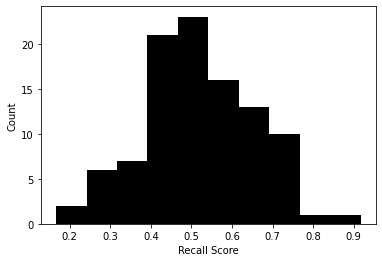

In [177]:
#Test 3, MLR no feature selection, no pca, scaling on,  downsampling, 8020 data split, high accuracy, 
# no emotion feature added basic alone
Recall_MLR_basic_6 = MLR_results['recall'].loc[MLR_results['Test'] == 6].plot(kind = 'hist', color ="black")
Recall_MLR_basic_6.set_xlabel("Recall Score")
Recall_MLR_basic_6.set_ylabel("Count")

Text(0, 0.5, 'Count')

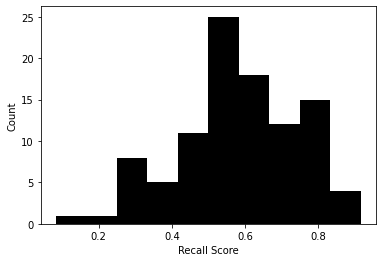

In [178]:
#Test 3, SVM Linear no feature selection, no pca, scaling on,  downsampling, 8020 data split, high accuracy, 
# no emotion feature added basic alone
Recall_SVM_basic_6 = linear_results['recall'].loc[linear_results['Test'] == 6].plot(kind = 'hist', color ="black")
Recall_SVM_basic_6.set_xlabel("Recall Score")
Recall_SVM_basic_6.set_ylabel("Count")

Text(0, 0.5, 'Count')

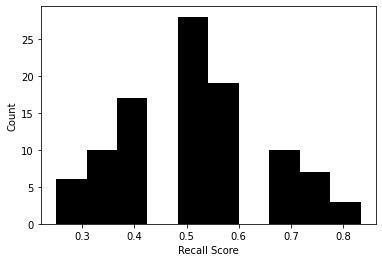

In [78]:
#Test 4, MLR no feature selection, no pca, scaling on,  downsampling, 8020 data split, high accuracy, 
#  emotion feature added basic alone
Recall_MLR_basic_8 = MLR_results['recall'].loc[MLR_results['Test'] == 8].plot(kind = 'hist', color ="black")
Recall_MLR_basic_8.set_xlabel("Recall Score")
Recall_MLR_basic_8.set_ylabel("Count")


Text(0, 0.5, 'Count')

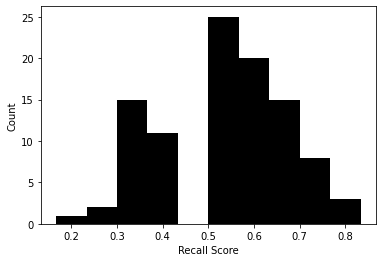

In [79]:
#Test 4, SVM Linear no feature selection, no pca, scaling on,  downsampling, 8020 data split, high accuracy, 
#  emotion feature added basic alone
Recall_SVM_basic_8 = linear_results['recall'].loc[linear_results['Test'] == 8].plot(kind = 'hist', color ="black")
Recall_SVM_basic_8.set_xlabel("Recall Score")
Recall_SVM_basic_8.set_ylabel("Count")

In [73]:
SVM_Round2_Results = stats.wilcoxon(linear_results['recall'].loc[linear_results['Test'] == 7], linear_results['recall'].loc[linear_results['Test'] == 8])
MLR_Round2_Results = stats.wilcoxon(MLR_results['recall'].loc[MLR_results['Test'] == 7], MLR_results['recall'].loc[MLR_results['Test'] == 8])


In [188]:
MLR_Round2_Results

WilcoxonResult(statistic=1225.0, pvalue=0.21588382084056867)

In [193]:
SVM_Round2_Results = stats.wilcoxon(linear_results['recall'].loc[linear_results['Test'] == 1], 
                                    linear_results['recall'].loc[linear_results['Test'] == 6])
MLR_Round2_Results = stats.wilcoxon(MLR_results['recall'].loc[MLR_results['Test'] == 1],
                                    MLR_results['recall'].loc[MLR_results['Test'] == 6])


print("MLR")
print("Round 2 MLR Wilcoxon: " + str(MLR_Round2_Results))
print("Test A Recall Mean: " + str(statistics.mean(MLR_results['recall'].loc[MLR_results['Test'] == 1])
) + " SD: " + str(statistics.stdev(MLR_results['recall'].loc[MLR_results['Test'] == 1])))

print("Test B Recall Mean: " + str(statistics.mean(MLR_results['recall'].loc[MLR_results['Test'] == 6])
) + " SD: " + str(statistics.stdev(MLR_results['recall'].loc[MLR_results['Test'] == 6])))

print("SVM")
print("Round 2 SVM Wilcoxon: " + str(SVM_Round2_Results))
print("Test Aure Recall Mean: " + str(statistics.mean(linear_results['recall'].loc[linear_results['Test'] == 1])
) + " SD: " + str(statistics.stdev(linear_results['recall'].loc[linear_results['Test'] == 1])))

print("Test B Recall Mean: " + str(statistics.mean(MLR_results['recall'].loc[MLR_results['Test'] == 6])
) + " SD: " + str(statistics.stdev(linear_results['recall'].loc[linear_results['Test'] == 6])))

MLR
Round 2 MLR Wilcoxon: WilcoxonResult(statistic=193.0, pvalue=0.07179960665365512)
Test A Recall Mean: 0.5258333333333334 SD: 0.14636207658927272
Test B Recall Mean: 0.5166666666666667 SD: 0.15214515486254615
SVM
Round 2 SVM Wilcoxon: WilcoxonResult(statistic=177.0, pvalue=0.7720185969766209)
Test Aure Recall Mean: 0.545 SD: 0.16851666850651373
Test B Recall Mean: 0.5166666666666667 SD: 0.166034153315937


In [75]:
print("Round 2 SVM Wilcoxon: " + str(SVM_Round2_Results))
print("Test with no Emotion Feature Recall Mean: " + str(statistics.mean(linear_results['recall'].loc[linear_results['Test'] == 7])
) + " SD: " + str(statistics.stdev(linear_results['recall'].loc[linear_results['Test'] == 7])))

print("Test with Emotion Feature Recall Mean: " + str(statistics.mean(MLR_results['recall'].loc[MLR_results['Test'] == 8])
) + " SD: " + str(statistics.stdev(linear_results['recall'].loc[linear_results['Test'] == 8])))

Round 2 SVM Wilcoxon: WilcoxonResult(statistic=531.0, pvalue=0.04420365151289131)
Test with no Emotion Feature Recall Mean: 0.545 SD: 0.16851666850651373
Test with Emotion Feature Recall Mean: 0.5141666666666667 SD: 0.14330112785162083
